In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import MultipleLocator

In [11]:
result=np.load('./npy/ne_result_mlp.npy', allow_pickle=True)
realrul=np.load('./npy/ne_real_mlp.npy', allow_pickle=True)

In [4]:
life = []
for i in range(realrul.shape[0]):
    life.append(len(realrul[i]))
print(life)

[1390, 1390, 1378, 545, 917, 736, 1390, 1024, 691, 1390, 867, 728, 736, 609, 1162, 971, 1268, 1034, 664, 924, 1390, 26, 213, 358, 439, 336, 363, 365, 380, 391, 373, 349, 387, 359, 397, 377, 413, 343, 377, 344, 335, 307, 591]


In [5]:
order_ne = [1,2,3,4,5,6,7,8,9,10,
            11,12,13,14,15,16,17,18,19,20,
            21,22,2,3,24,25,26,27,28,29,30,
            31,32,33,34,35,36,37,38,39,40,
            41,42]

In [71]:
print(order_ne)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2, 3, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


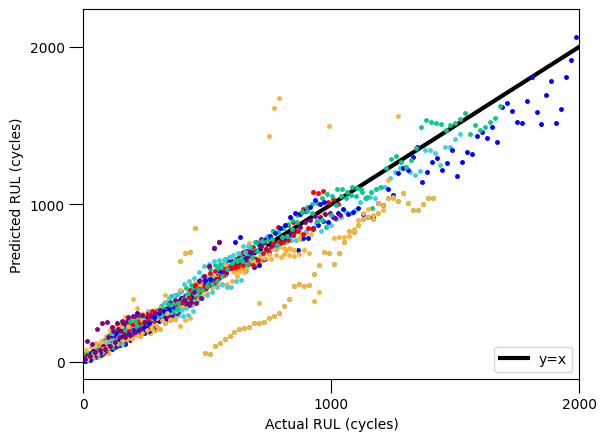

In [8]:
interval =20
x_lim = 2000
colors = ['#09C988','b','#FDB137','PURPLE','#40CEE3','red',
        '#09C988','b','#FDB137','PURPLE','#40CEE3','red',
        '#09C988','b','#FDB137','PURPLE','#40CEE3','red',
        '#09C988','b','#FDB137','PURPLE','#40CEE3','red',
        '#09C988','b','#FDB137','PURPLE','#40CEE3','red',
        '#09C988','b','#FDB137','PURPLE','#40CEE3','red',
        '#09C988','b','#FDB137','PURPLE','#40CEE3','red',
        '#09C988','b','#FDB137','PURPLE','#40CEE3','red']
# plt.plot(result[1])
# plt.plot(realrul[1])
plt.style.use('default')
plt.plot(range(x_lim), range(x_lim),'-',c='black', linewidth=3,label='y=x')
color = 0
for i in order_ne:
    if i == 0:
        continue
    if i == 1:
        continue
    if i == 21:
        continue
    if i == 42:
        continue
    plt.plot(realrul[i][::20]*3000, result[i][::20]*3000, '.',markersize=5,c=colors[color])
    color = color +1
plt.legend(fontsize=10,loc="lower right")
x_major_locator=MultipleLocator(400)
y_major_locator=MultipleLocator(400)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlim((0,x_lim))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(length=10)
plt.xticks([0,1000,2000],size=10)
plt.yticks([0,1000,2000],size=10)
# plt.gca().set_facecolor('white')
plt.ylabel('Predicted RUL (cycles)',fontsize=10,family='Avenir')
plt.xlabel('Actual RUL (cycles)',fontsize=10,family='Avenir')

plt.savefig("./figure/NE-OUR.png",dpi=1200,bbox_inches='tight')
plt.show()




<Figure size 900x300 with 0 Axes>

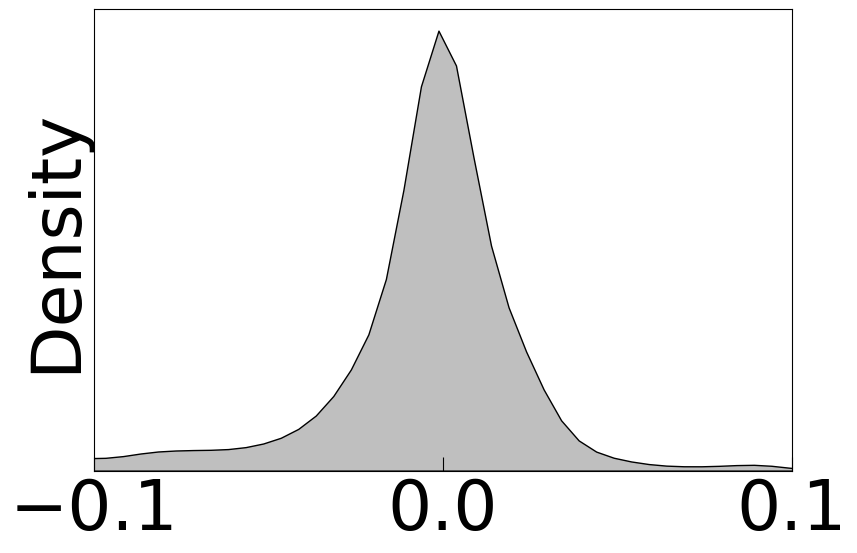

In [10]:
fig = plt.figure(figsize=(9,3))
cmap = plt.get_cmap('YlGnBu')
norm = plt.Normalize(vmin=0.3, vmax=1)
error_list = []

colors = ['k','mediumpurple','red','chocolate','limegreen','steelblue',]
label_names = ['#1', '#50','#65','#70', '#73', '#76' ]

for i in order_ne:
    if i == 0:
        continue
    if i == 1:
        continue
    if i == 21:
        continue
    if i == 42:
        continue
    interval = 1
    rul_true = realrul[i]
    rul_pred = result[i]
    tmp = rul_pred[::interval] - rul_true[::interval]
    error_list.append(tmp.reshape(-1,1))
    
error_array = np.vstack(error_list)

fig = plt.figure(figsize=(9,6))
sns.kdeplot(error_array.squeeze(),shade=True,color='k')
plt.xticks([-0.1, 0, 0.1],size=50)
plt.yticks([],size=5)
plt.xlim(-0.1,0.1)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(length=10)
plt.ylabel('Density',fontsize=50,family='Avenir')
plt.savefig("./figure/NE-OUR-dens.png",dpi=1200,bbox_inches='tight')
plt.show()

In [13]:
import os
import time
import pickle
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
from scipy import interpolate
from datetime import datetime
import pandas as pd
from tool import EarlyStopping
from sklearn.metrics import roc_auc_score,mean_squared_error,mean_absolute_error, r2_score

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, Sampler, TensorDataset
from torch.utils.data.sampler import RandomSampler
    
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')



import numpy as np

In [14]:
life = [1390, 1390, 1378, 545, 917, 736, 1390, 1024, 691, 1390, 867, 728, 736, 609, 1162, 971, 1268, 1034, 664, 924, 1390, 26, 213, 358, 439, 336, 363, 365, 380, 391, 373, 349, 387, 359, 397, 377, 413, 343, 377, 344, 335, 307, 591]

In [15]:
cols = ['rmse_after', 'r2_after', 'mae_after']

# 创建一个空的 DataFrame
table_wx = pd.DataFrame(index=range(realrul.shape[0]), columns=cols)

for i in range(realrul.shape[0]):
    if i == 0:
        continue
    if i == 1:
        continue
    if i == 21:
        continue
    if i == 42:
        continue
    rul_true = realrul[i]*3000
    rul_pred = result[i]*3000
    A_life = 2000
    
    rmse_after = np.sqrt(mean_squared_error(rul_true, rul_pred))
    r2_after = r2_score(rul_true, rul_pred)
    mae_after = mean_absolute_error(rul_true, rul_pred)/life[i]  * 100
    
    # 在 DataFrame 中保存结果
    table_wx.iloc[i] = [rmse_after, r2_after, mae_after]

# 计算每列的平均值
averages = table_wx.mean()

# 在 DataFrame 的最后一行添加平均值
table_wx.loc['Average'] = averages

# 显示结果
print(table_wx)


        rmse_after  r2_after mae_after
0              NaN       NaN       NaN
1              NaN       NaN       NaN
2          367.202  0.147895   23.9061
3          61.9678  0.844861   6.49027
4          63.3973  0.942643   5.55242
5          19.8282  0.991291   2.14927
6          51.2196  0.983706   2.62968
7           34.714  0.986209   2.70333
8          47.2622  0.943862   6.34336
9          249.039  0.614799    14.139
10         61.7688  0.939091    5.3378
11         27.4946  0.982884   2.86278
12         34.3861  0.973807   4.00798
13         26.4847  0.977305   3.85051
14         82.3051  0.939796   6.42476
15         183.463  0.571609   12.7485
16          287.93  0.381246   17.7115
17         160.577  0.710593   13.7055
18         64.3029   0.88746   7.62032
19         51.7638  0.962339   4.93538
20         64.6343  0.974054   3.67711
21             NaN       NaN       NaN
22         55.0573  0.198209   22.3991
23          43.817  0.820236   7.94845
24         79.7592  0.603

In [16]:
import pandas as pd

# 假设 table_wx 是您的 DataFrame
table_wx.to_excel("./results/ne_mlp.xlsx", engine='openpyxl')
